In [7]:
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
import inflect
import re
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold
from nltk.corpus import stopwords
import numpy as np


# nltk.download('stopwords')
# nltk.download('gutenberg', quiet=True)
# nltk.download('punkt', quiet=True)

# imdb_data = pd.read_csv(r'https://raw.githubusercontent.com/BubbleNeumann/University-tasks/master/sem8_nlp_lab2/dataset.csv')
imdb_data = pd.read_csv('dataset.csv')
print(imdb_data.shape)

(50000, 2)


#### step 1. prep data

In [8]:
def prep(x: str):
    x = re.sub(r'<br />', '', x.lower())
    x = re.sub(r'[^\w\s]', '', x)
    tokens = word_tokenize(x)

    # replace digits with their text representation
    infl = inflect.engine()
    sentence = re.sub(r'\d+', lambda match: infl.number_to_words(match.group()), x)

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # join the filtered tokens back into a sentence
    return ' '.join(filtered_tokens)

In [9]:
x_data, y_data = imdb_data['review'][:10000], imdb_data['sentiment'][:10000]

y_train = y_data.apply(lambda x: int(x.startswith('p')))
x_train, x_test, y_train, y_test = train_test_split(x_data, y_train, test_size=0.1)

x_train = list(map(prep, x_train))

В качестве исследуемых способов представления текстов необходимо рассмотреть:

#### 1.Компоненты вектора: частоты ([CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)).

In [10]:
%%time
cv = CountVectorizer(max_features=500)
x_cv = cv.fit_transform(x_train)

CPU times: user 1.28 s, sys: 27 ms, total: 1.31 s
Wall time: 1.34 s


In [5]:
x_cv_test = cv.transform(x_test)  # prep the test set

#### 2. Компоненты вектора: оценки tf-idf для слова ([TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)).

In [11]:
%%time
tfidf = TfidfVectorizer(max_features=500)
x_tfidf = tfidf.fit_transform(x_train)

CPU times: user 1.43 s, sys: 5.56 ms, total: 1.44 s
Wall time: 1.48 s


#### 3. Компоненты вектора: частоты N-грам.

In [12]:
%%time
cv_ngram = CountVectorizer(ngram_range=(2, 2), max_features=500)
x_ngram = cv_ngram.fit_transform(x_train)

CPU times: user 4.34 s, sys: 184 ms, total: 4.53 s
Wall time: 4.53 s


### Шаг 2. Исследование моделей

<table>
		<tr>
			<td></td>
			<td>$y = 1$</td>
			<td>$y = 0$</td>
		</tr>
		<tr>
			<td>$a(x) = 1$</td>
			<td>True Positive (TP)</td>
			<td>False Positive (FP)</td>
		</tr>
    	<tr>
			<td>$a(x) = 0$</td>
			<td>False Negative (FN)</td>
			<td>True Negative (TN)</td>
		</tr>
</table>

В зависимости от способа представления оценить качество классификации как долю правильных ответов на выборке ($\operatorname{accuracy} = \frac{\operatorname{TP} + \operatorname{TN}}{\operatorname{TP} + \operatorname{TN} + \operatorname{FP} + \operatorname{FN}}$). Используйте перекрестную проверку ([cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html), [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)).

Для каждого из нижеперечисленных моделей необходимо определить оптимальные гиперпараметры ([GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html))

Качество классификации оцениваем для следующих моделей:

#### 1. Машина опорных векторов ([SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)).

In [14]:
%%time

stats_svc = []
svc_models = []  # list of models with best params

for X in [x_cv, x_tfidf, x_ngram]:
    clf = GridSearchCV(
        SVC(),
        # {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'gamma': [0.1, 0.01, 0.001], 'C': [0.1, 1, 10, 25], }
        { 'kernel':('poly', 'rbf', 'sigmoid'), 'C': [1, 10] },
        verbose=3
    )
    clf.fit(X, y_train) # fit on the transformed data
    # cl = SVC(kernel=clf.best_params_['kernel'], C=clf.best_params_['C'], gamma=clf.best_params_['gamma'])
    cl = SVC(kernel=clf.best_params_['kernel'], C=clf.best_params_['C'])
    # k_fold = KFold(n_splits=5, shuffle=True, random_state=42)  # define 5-fold cross-validation
    acc = cross_val_score(cl, X, y_train, scoring='accuracy', verbose=3) # evaluate accuracy
    stats_svc.append((clf.best_params_, acc))
    svc_models.append(cl)
    

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ..................C=1, kernel=poly;, score=0.697 total time=  17.8s
[CV 2/5] END ..................C=1, kernel=poly;, score=0.714 total time=  17.9s
[CV 3/5] END ..................C=1, kernel=poly;, score=0.694 total time=  17.6s
[CV 4/5] END ..................C=1, kernel=poly;, score=0.677 total time=  17.6s
[CV 5/5] END ..................C=1, kernel=poly;, score=0.693 total time=  17.7s
[CV 1/5] END ...................C=1, kernel=rbf;, score=0.821 total time=  15.3s
[CV 2/5] END ...................C=1, kernel=rbf;, score=0.833 total time=  14.5s
[CV 3/5] END ...................C=1, kernel=rbf;, score=0.831 total time=  14.7s
[CV 4/5] END ...................C=1, kernel=rbf;, score=0.818 total time=  15.9s
[CV 5/5] END ...................C=1, kernel=rbf;, score=0.819 total time=  15.4s
[CV 1/5] END ...............C=1, kernel=sigmoid;, score=0.663 total time=   9.3s
[CV 2/5] END ...............C=1, kernel=sigmoid;,

In [23]:
for e in stats_svc:
    print(np.round(np.average(e[1]), 3))

0.824
0.831
0.689


In [ ]:
svc_models[0].fit(x_cv, y_train)
# svc_cv_prediction = cl.predict(x_cv_test)
accuracy = svc_models[0].score(x_cv_test, y_test)
    

#### 2. Случайный лес ([RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)).

In [10]:
%%time

stats_rfc = []

for X in [x_cv, x_tfidf, x_ngram]:
    clf = GridSearchCV(
        RandomForestClassifier(random_state=1234),
        # {'n_estimators': [10, 200, 1000], 'criterion': ('gini', 'entropy', 'log_loss')}
        {'n_estimators': [10, 100], 'criterion': ('gini', 'entropy')}
    )
    clf.fit(X, y_train)
    cl = RandomForestClassifier(criterion=clf.best_params_['criterion'], random_state=1234, n_estimators=clf.best_params_['n_estimators'])
    k_fold = KFold(n_splits=5, shuffle=True, random_state=42)  # define 5-fold cross-validation
    acc = cross_val_score(cl, X, y_train, cv=k_fold, scoring='accuracy')
    stats_rfc.append((clf.best_params_, acc))

CPU times: user 3h 16min 26s, sys: 2.84 s, total: 3h 16min 29s
Wall time: 3h 16min 32s


### Шаг 3. Сравнение результатов

Сравнить точность обученных моделей. Найти наиболее точную.

In [11]:
for e in zip(['CountVectorizer', 'TfidfVectorizer', 'Ngrams' ], stats_svc):
    print(e)

for e in zip(['CountVectorizer', 'TfidfVectorizer', 'Ngrams' ], stats_rfc):
    print(e)

('CountVectorizer', ({'C': 10, 'kernel': 'rbf'}, array([0.82592593, 0.81666667, 0.83518519, 0.80740741, 0.86851852])))
('TfidfVectorizer', ({'C': 1, 'kernel': 'sigmoid'}, array([0.87037037, 0.85185185, 0.85925926, 0.84074074, 0.86296296])))
('Ngrams', ({'C': 10, 'kernel': 'sigmoid'}, array([0.58703704, 0.56481481, 0.57407407, 0.60185185, 0.59814815])))
('CountVectorizer', ({'criterion': 'entropy', 'n_estimators': 1000}, array([0.85185185, 0.82407407, 0.83333333, 0.81851852, 0.86296296])))
('TfidfVectorizer', ({'criterion': 'entropy', 'n_estimators': 1000}, array([0.84444444, 0.82037037, 0.84814815, 0.81296296, 0.87037037])))
('Ngrams', ({'criterion': 'entropy', 'n_estimators': 1000}, array([0.53518519, 0.51111111, 0.52592593, 0.53333333, 0.57037037])))


In [17]:
print(stats_rfc[0][1])

[0.85185185 0.82407407 0.83333333 0.81851852 0.86296296]


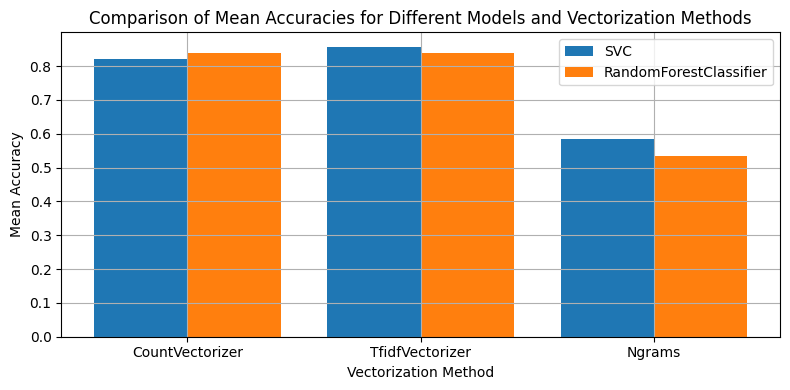

In [20]:
# Accuracy data
accuracy_data = [
    ('SVC', 'CountVectorizer', [0.82, 0.81, 0.83, 0.8 , 0.8, 0.86]),
    ('SVC', 'TfidfVectorizer', [0.87037037, 0.85185185, 0.85925926, 0.84074074, 0.86296296]),
    ('SVC', 'Ngrams', [0.58703704, 0.56481481, 0.57407407, 0.60185185, 0.59814815]),
    ('RandomForestClassifier', 'CountVectorizer', [0.85185185, 0.82407407, 0.83333333, 0.81851852, 0.86296296]),
    ('RandomForestClassifier', 'TfidfVectorizer', [0.84444444, 0.82037037, 0.84814815, 0.81296296, 0.87037037]),
    ('RandomForestClassifier', 'Ngrams', [0.53518519, 0.51111111, 0.52592593, 0.53333333, 0.57037037])
]

# Organizing data
models = ['SVC', 'RandomForestClassifier']
methods = ['CountVectorizer', 'TfidfVectorizer', 'Ngrams']
mean_accuracies = {model: {method: np.mean([scores for m, n, scores in accuracy_data if m == model and n == method]) for method in methods} for model in models}

# Plotting
plt.figure(figsize=(8, 4))

x = np.arange(len(methods))
width = 0.4

for i, model in enumerate(models):
    plt.bar(x + i * width, mean_accuracies[model].values(), width=width, label=model)

plt.xlabel('Vectorization Method')
plt.ylabel('Mean Accuracy')
plt.title('Comparison of Mean Accuracies for Different Models and Vectorization Methods')
plt.xticks(x + width / 2, methods)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
